## **robustness_checker**

### **Import libraries**

In [1]:
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import average_precision_score, brier_score_loss
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import os

### **Load the dataset**

In [2]:
os.chdir("../")
print(os.getcwd())

d:\MLops\NetworkSecurity


In [3]:


SEED = 42
CLEAN = Path("data/processed/phiusiil_clean.csv")
RAW = Path("data/raw/PhiUSIIL_Phishing_URL_Dataset.csv")
DATA = CLEAN if CLEAN.exists() else RAW
print("Checking for:", CLEAN.resolve())
print("Exists?", CLEAN.exists())
print(f"Using dataset: {DATA}")

Checking for: D:\MLops\NetworkSecurity\data\processed\phiusiil_clean.csv
Exists? True
Using dataset: data\processed\phiusiil_clean.csv


###  **Load & basic prep**

This code block loads the dataset, automatically locates the label column, and prepares the target variable and features for modeling. It ensures that only numeric columns are used as features, removes the label and URL columns, and prints out the number of numeric features available for analysis. The data is then split into training and validation sets with stratified sampling to maintain class balance, and a version of the validation labels is created to support precision-recall metrics focused on phishing detection.

In [ ]:

df = pd.read_csv(DATA, encoding_errors="ignore")

label_col = next((c for c in df.columns if c.lower() in {"label","result","y","target"}), None)
assert label_col, "No label column found"

y = df[label_col].astype(int).values             # 1=legit, 0=phish
y_phish = (y == 0).astype(int)                   # for PR-AUC where positive=phish

urls = df["URL"].astype(str).values if "URL" in df.columns else np.array([""]*len(df))
X_all = df.drop(columns=[label_col])
if "URL" in X_all.columns:
    X_all = X_all.drop(columns=["URL"])

X_all = X_all.select_dtypes(include=["number"]).copy()
print(f"Features: {X_all.shape[1]} numeric columns")

X_train, X_val, y_train, y_val, u_train, u_val = train_test_split(
    X_all, y, urls, test_size=0.20, stratify=y, random_state=SEED
)

y_val_phish = (y_val == 0).astype(int)

Features: 50 numeric columns


### **Utility: fit a small XGB and return p_mal = P(phish)**

This function trains an XGBoost classifier to predict the probability that a sample is phishing, using the provided training features and labels. It sets up the model with specific hyperparameters, converts the labels so that phishing is treated as the positive class, and returns the predicted probabilities for the test set. This utility helps quickly evaluate how well the model can distinguish phishing samples from legitimate ones.

In [5]:
def fit_xgb(Xtr, ytr, Xte, seed=SEED, n_estimators=200):
    clf = XGBClassifier(
        n_estimators=n_estimators, max_depth=6, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=seed, n_jobs=0, objective="binary:logistic"
    )
    clf.fit(Xtr, (ytr==0).astype(int))              # train with phish=1 target
    p_phish = clf.predict_proba(Xte)[:,1]           # P(phish)
    return p_phish

### **A1-** **Label-shuffle baseline**

This code block tests the model’s robustness by randomly shuffling the phishing labels in the training set, breaking any real relationship between features and labels. It then trains the model on this shuffled data and evaluates its performance on the validation set, expecting metrics like average precision and Brier score to drop to chance levels (around 0.5 for AP). This helps confirm that the model is not learning shortcuts or artifacts from the data, and that high scores on real data are meaningful.

In [6]:
rng = np.random.default_rng(SEED)
y_train_shuf = rng.permutation((y_train==0).astype(int))  # shuffle phish labels
p_shuf = fit_xgb(X_train, 1 - y_train_shuf, X_val)        # invert back to y-coding for fit helper
ap_shuf = average_precision_score(y_val_phish, p_shuf)
brier_shuf = brier_score_loss(y_val_phish, p_shuf)
print(f"[A1] Label-shuffle   → AP={ap_shuf:.3f} (≈0.5 expected), Brier={brier_shuf:.3f}")

[A1] Label-shuffle   → AP=0.422 (≈0.5 expected), Brier=0.247


### **A2- Single-feature PR-AUC scanning**

This code scans each feature in the validation set to see how well it alone can separate phishing from legitimate samples, using average precision (AP) as the metric. It tests both the original and inverted values of each feature to account for sign direction, then records the best AP for each. Features with very high AP (>0.995) are flagged as potential shortcuts, meaning they might allow the model to easily distinguish classes due to data artifacts or policy-sensitive information.

In [7]:
ap_rows = []
for col in X_all.columns:
    s_val = X_val[col].values.astype(float)
    # Use both orientations; take the best AP (since sign may be arbitrary)
    ap1 = average_precision_score(y_val_phish, s_val)
    ap2 = average_precision_score(y_val_phish, -s_val)
    ap_rows.append((col, float(max(ap1, ap2))))
ap_df = pd.DataFrame(ap_rows, columns=["feature", "ap_max"])
ap_df.sort_values("ap_max", ascending=False, inplace=True)
top10 = ap_df.head(10)
n_shortcuts = (ap_df["ap_max"] > 0.995).sum()
print(f"[A2] Top-10 single-feature AP (max over orientation):\n{top10.to_string(index=False)}")
print(f"[A2] Features with AP>0.995: {n_shortcuts}  (flagged as policy-sensitive)")

[A2] Top-10 single-feature AP (max over orientation):
                   feature   ap_max
        URLSimilarityIndex 0.995497
                LineOfCode 0.988937
           NoOfExternalRef 0.979716
                 NoOfImage 0.966242
                    NoOfJS 0.955238
               NoOfSelfRef 0.936094
                   NoOfCSS 0.929496
         LargestLineLength 0.853622
NoOfOtherSpecialCharsInURL 0.791699
     SpacialCharRatioInURL 0.783111
[A2] Features with AP>0.995: 1  (flagged as policy-sensitive)


### **A3- Degeneracy check on p_mal vals**

This code trains the model on the true labels and predicts phishing probabilities for the validation set. It then checks how many predictions are extremely close to 0 or 1, which can indicate overconfident or degenerate outputs. The average precision and Brier score are calculated to assess model performance, and a histogram visualizes the distribution of predicted probabilities.

[A3] True model   → AP=1.000, Brier=0.000005
[A3] Prob mass near 0: 0.567 | near 1: 0.425


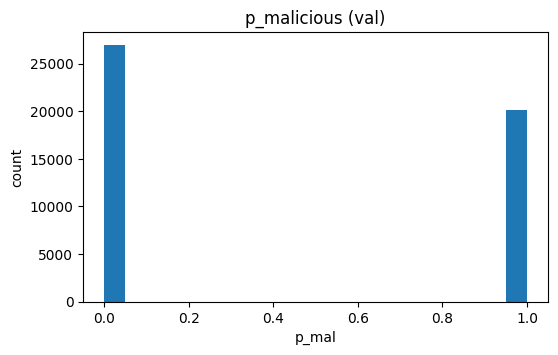

In [8]:
p_mal = fit_xgb(X_train, y_train, X_val)
share_near_0 = (p_mal <= 1e-4).mean()
share_near_1 = (p_mal >= 1 - 1e-4).mean()
ap_true = average_precision_score(y_val_phish, p_mal)
brier_true = brier_score_loss(y_val_phish, p_mal)
print(f"[A3] True model   → AP={ap_true:.3f}, Brier={brier_true:.6f}")
print(f"[A3] Prob mass near 0: {share_near_0:.3f} | near 1: {share_near_1:.3f}")
plt.figure(figsize=(6,3.5)); plt.hist(p_mal, bins=20); plt.title("p_malicious (val)"); plt.xlabel("p_mal"); plt.ylabel("count"); plt.show()

### **A4- Cross-split duplicate URL contamination**

This code checks for any duplicate URLs that appear in both the training and validation sets, which could cause data leakage and inflate model performance. It then saves the single-feature average precision (AP) results to a CSV file for further review, making it easier to identify features that may act as shortcuts or have unusually high predictive power.

In [9]:
if urls.size and urls.dtype.kind in {"U","S","O"}:
    inter = set(u_train).intersection(set(u_val))
    print(f"[A4] Train/Val overlapping URLs: {len(inter)} (should be 0 after dedup)")
else:
    print("[A4] URL column not available for overlap test")
    
# Save the single-feature AP table for review
out_dir = Path("outputs/robustness"); out_dir.mkdir(parents=True, exist_ok=True)
ap_df.to_csv(out_dir/"single_feature_ap.csv", index=False)
print(f"[A2] Wrote single-feature AP table → {out_dir/'single_feature_ap.csv'}")

[A4] Train/Val overlapping URLs: 0 (should be 0 after dedup)
[A2] Wrote single-feature AP table → outputs\robustness\single_feature_ap.csv
